In [20]:
import numpy as np
import networkx as nx
from dwdynamics import ComplexDynamicsProblem, Objective,helpers ,instance# Difference a. We are using ComplexDynamicsProblem
import matplotlib.pyplot as plt
import json
import os
from dwave_networkx.generators.pegasus import (get_tuple_defragmentation_fn, fragmented_edges,
    pegasus_coordinates, pegasus_graph)
from dwave.system import DWaveSampler, EmbeddingComposite
import matplotlib.pyplot as plt
from collections import defaultdict
import re
from tqdm import tqdm
import scipy 
import pickle as pckl

In [21]:
import sys
print(sys.path[1])

/usr/lib/python313.zip


In [22]:
import os
import re
import pandas as pd
import numpy as np
import math
import dimod.sampleset


# List instances

In [51]:
path = f'../data/instances/'
for item in os.listdir(path):
    if item[-5:] == '.pckl':    
        with open(os.path.join(path, item),'rb') as f:
            print(f"---------- System {item} ------------")
            data = pckl.load(f)
            print(data['about'])


---------- System 6.pckl ------------
np.pi/2*|000><111|+|111><000|
---------- System 8.pckl ------------
2 qubits with a lot of 0.5 0.5j
---------- System 7.pckl ------------
np.pi*helpers.generate_pt_symmetric_real_eig(0.5)
---------- System 5.pckl ------------
|00><11|+|00><11|
---------- System 3.pckl ------------
V=1/np.sqrt(2)*(sigma_y+sigma_z), D = np.diag([0.25,0.5])
---------- System 1.pckl ------------
0.5PI * SY
---------- System 2.pckl ------------
np.pi*1/math.sqrt(2)(X+Z)
---------- System 10.pckl ------------
np.pi/2*helpers.create_entangled_hamiltonian(4)
---------- System 4.pckl ------------
maximally entangled qubit


# Analyze

In [24]:
def load_data(raw = False,topology='6.4',system=1):
    path = f'../data/results/hessian/{system}/'

    dfs = []
    for topology in [topology]:
        path += topology
        for file in os.listdir(path):
            precision = int(re.findall('(?<=precision_)\d+',file)[0])
            timepoints = int(re.findall('(?<=timepoints_)\d+',file)[0])
            with open(os.path.join(path,file),'r') as f:
                s = dimod.SampleSet.from_serializable(json.load(f))
        
            qpu_access_time = s.info['timing']['qpu_access_time']
            s = s.to_pandas_dataframe()
            if not raw:
                s = s[['energy','num_occurrences']]
            s['systemid'] = topology
            s['precision'] = precision
            s['timepoints'] = timepoints
            s['energy'] = abs(round(s['energy'],10))
            s['access_time'] = (qpu_access_time / s['num_occurrences'].sum()) * s['num_occurrences'] * 1e-3
            dfs.append(s)

    dfs_all = pd.concat(dfs)

    return dfs_all

def get_precision_timepoints_pairs(dfs):
    dfs = dfs.groupby(['precision','timepoints'])['num_occurrences'].count()
    return list(set(dfs.index))

<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_19328/1828539798.py:8: SyntaxWarning: invalid escape sequence '\d'
  precision = int(re.findall('(?<=precision_)\d+',file)[0])
/tmp/ipykernel_19328/1828539798.py:9: SyntaxWarning: invalid escape sequence '\d'
  timepoints = int(re.findall('(?<=timepoints_)\d+',file)[0])


In [25]:
topology='6.4'
dfs_all = load_data(topology=topology,system=4)
dfs_all_rounded = dfs_all.copy()
dfs_all_rounded['energy'] = dfs_all_rounded['energy'].apply(lambda x: math.ceil(x)) # for displaying in a histogram


In [26]:
dfs_grouped =dfs_all.groupby(['systemid', 'precision','timepoints','energy'])['num_occurrences'].sum() 
dfs_grouped_rounded = dfs_all_rounded.groupby(['systemid', 'precision','timepoints','energy'])['num_occurrences'].sum()
dfs_keys = set([(key[0],key[1],key[2]) for key in dfs_grouped.keys()])
for key in dfs_keys:
    dfs_grouped[key] = dfs_grouped[key] / dfs_grouped[key].sum() * 100
    dfs_grouped_rounded[key] = dfs_grouped_rounded[key] / dfs_grouped_rounded[key].sum() * 100

dfs_grouped_rounded 

/tmp/ipykernel_19328/4200412015.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.06  0.58  2.02  5.36  9.94 14.76 17.24 16.32 13.6   9.12  5.42  3.1
  1.36  0.54  0.36  0.08  0.1   0.04]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfs_grouped[key] = dfs_grouped[key] / dfs_grouped[key].sum() * 100
/tmp/ipykernel_19328/4200412015.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.64  7.38 24.7  33.56 22.72  8.52  1.9   0.44  0.14]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfs_grouped_rounded[key] = dfs_grouped_rounded[key] / dfs_grouped_rounded[key].sum() * 100


systemid  precision  timepoints  energy
6.4       2          2           0          3.60
                                 1         37.64
                                 2         44.26
                                 3         13.16
                                 4          1.26
                                 5          0.08
                     3           0          0.44
                                 1         11.48
                                 2         35.80
                                 3         36.92
                                 4         12.58
                                 5          2.40
                                 6          0.36
                                 7          0.02
                     4           0          0.10
                                 1          3.16
                                 2         19.92
                                 3         36.68
                                 4         26.60
                             

# Interpret results

<>:25: SyntaxWarning: invalid escape sequence '\p'
<>:72: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\p'
<>:72: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_19328/2927636473.py:25: SyntaxWarning: invalid escape sequence '\p'
  1: 'H = $\frac{\pi}{2}\sigma_y$',
/tmp/ipykernel_19328/2927636473.py:72: SyntaxWarning: invalid escape sequence '\d'
  dfs_filtered = dfs_filtered.filter(regex='\d+')


[[-0.5-0.5j -0.5-0.5j]
 [ 0.5+0.5j -0.5-0.5j]]
(2, 2)
[[-0.5-0.5j -0.5-0.5j]
 [ 0.5+0.5j -0.5-0.5j]]
[[-0.5-0.5j -0.5-0.5j]
 [ 0.5+0.5j -0.5-0.5j]]
(2, 2)
[[-0.5-0.5j -0.5-0.5j]
 [ 0.5+0.5j -0.5-0.5j]]
[[-0.5-0.5j -0.5-0.5j]
 [ 0.5+0.5j -0.5-0.5j]]
[[-0.5-0.5j -0.5-0.5j]
 [ 0.5+0.5j -0.5-0.5j]]
(2, 2)
[[-0.5-0.5j -0.5-0.5j]
 [ 0.5+0.5j -0.5-0.5j]]
[[-0.5-0.5j -0.5-0.5j]
 [ 0.5+0.5j -0.5-0.5j]]
[[-0.5-0.5j -0.5-0.5j]
 [ 0.5+0.5j -0.5-0.5j]]
[[-0.5-0.5j -0.5-0.5j]
 [ 0.5+0.5j -0.5-0.5j]]
(2, 2)


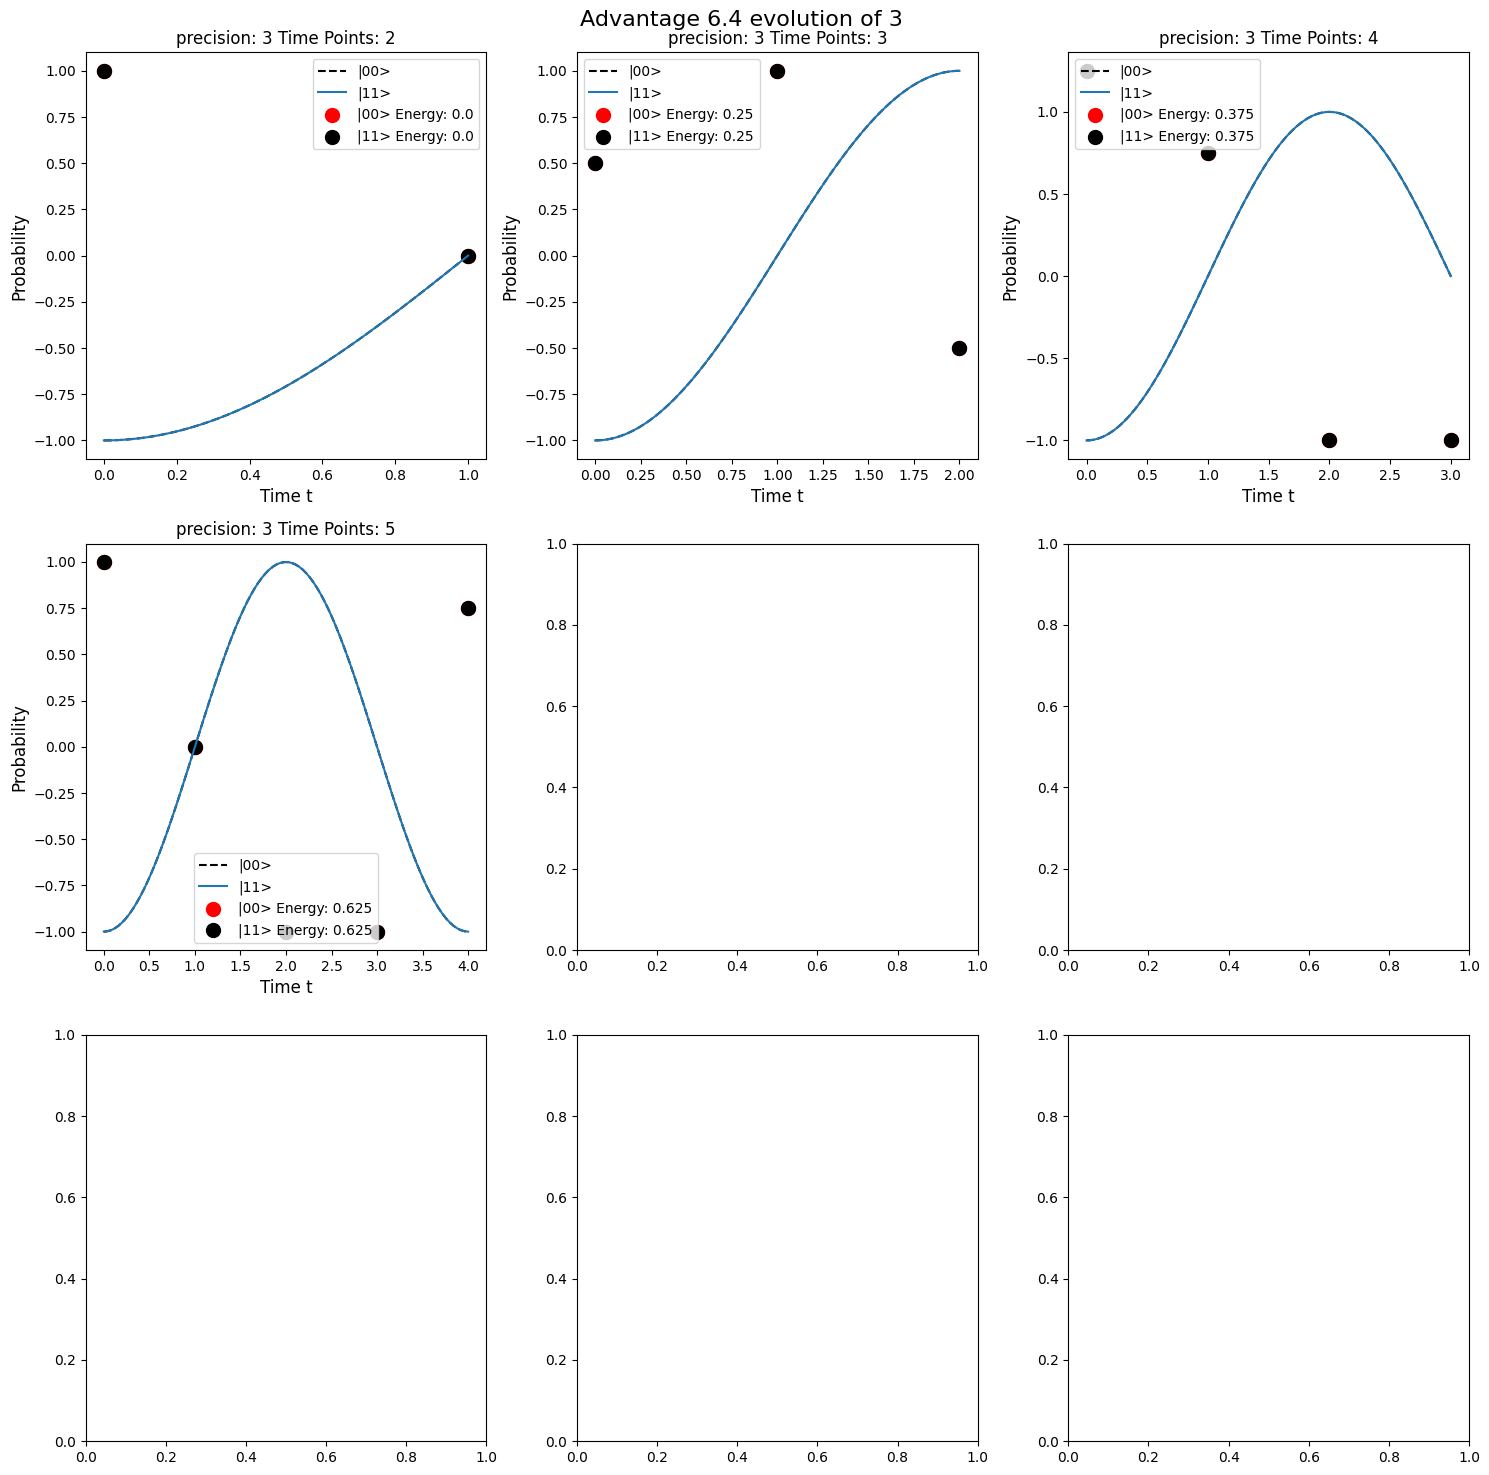

In [27]:
import qutip as qp

system = 3

dfs_data_raw = load_data(raw=True,system=system)
tp_pairs = get_precision_timepoints_pairs(dfs_data_raw)
tp_pairs.sort(key=lambda x: x[0]*10 + x[1])
dfs_data_raw['systemid']
# We simulate evolution under the Hamiltonian 1/2 pi * Sigma_y...

# Loop over all rows in velox_results and plot all dynamics on the same panel,
# coloring each curve according to its best_energy.
colors = ["r", "g", "b", "c", "m", "y", "k"]
markers = ["o", "s", "^", "D", "v", "<", ">"]

SY = np.array([[0, -1.0j], [1.0j, 0.0]])
PSI0 = np.array([1, 0], dtype=np.complex128)  # Difference b. Initial state can now be complex.


# Create a single axis for the plot
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=False)
axes = axes.flatten()

system_latex_dict = {
    1: 'H = $\frac{\pi}{2}\sigma_y$',
    3: 'one qubit pt symmetric system (seed=1)',
    4: 'maximally entangled 2 qubit system'
}




for i, (precision,timepoints) in enumerate(tp_pairs):
    inst = instance.Instance(system)
    inst.create_instance(precision, timepoints)
    H = inst.H
    PSI0 = inst.psi0
    dim = int(math.log2(H.shape[0]))    #dim=2

    print(H.shape)
    #H = instance['H']

    #baseline 
    # Projectors on |0..0⟩ and |1..1⟩
    P_00 = qp.tensor([qp.basis(2, 0)]*dim).proj()
    P_11 = qp.tensor([qp.basis(2, 1)]*dim).proj()

    P_00 = qp.tensor([qp.sigmaz()]+ [qp.qeye(2)]*(dim-1))
    P_11 = qp.tensor([qp.qeye(2)]*(dim-1) + [qp.sigmaz()])

    H_qp = qp.Qobj(H,dims=[[2]*dim,[2]*dim])

    psi_0 = qp.basis(2**dim, 1)
    psi_0.dims = [[2]*dim, [1]]  # Naprawa błędu wymiarów

    #psi_0 = qp.tensor(qp.basis(2, 0), qp.basis(2, 1))
    times = np.linspace(0, timepoints-1, 100)
    baseline = qp.mesolve(H_qp, psi_0, times, e_ops=[P_00,P_11]).expect
    ax = axes[i]

    ax.plot(times, baseline[0], "k--",label="|00>")
    ax.plot(times, baseline[1],label="|11>")


    problem = inst.problem
    dfs_filtered = dfs_data_raw[(dfs_data_raw.precision == precision) & (dfs_data_raw.timepoints == timepoints)]
    dfs_filtered = dfs_filtered.drop(['num_occurrences'],axis=1)
    dfs_filtered.drop_duplicates(inplace=True)
    dfs_filtered = dfs_filtered.sort_values(by='energy').head(1)
    dfs_filtered = dfs_filtered.sort_values(by='energy',ascending=False)
    energies = list(dfs_filtered['energy'])
    dfs_filtered = dfs_filtered.filter(regex='\d+')
    dfs_filtered = dfs_filtered.apply(pd.to_numeric)
    for j, (_, row) in enumerate(dfs_filtered.iterrows()): 
        sol_dict = row.dropna().to_dict()
        sol_dict = {key:int(value) for key,value in sol_dict.items()}

        vec =problem.interpret_sample(sol_dict)

        expect_00 = [(state.conj() @ P_00.full() @ state).real for state in vec]
        expect_11 = [(state.conj() @ P_11.full() @ state).real for state in vec]

        ax.scatter(problem.times, expect_00, color=colors[j % len(colors)], marker=markers[j % len(markers)], label=f"|00> Energy: {round(energies[j],4)}", alpha=1.0, s=100)
        ax.scatter(problem.times, expect_11, color='black', marker=markers[j % len(markers)],label=f"|11> Energy: {round(energies[j],4)}", alpha=1.0, s=100)

        #ax.plot(problem.times, expect, color=colors[j % len(colors)], alpha=0.5, linewidth=0.1)
    ax.set_xlabel("Time t", fontsize=12)
    ax.set_ylabel(r"Probability", fontsize=12)
    ax.set_title(f"precision: {problem.num_bits_per_var} Time Points: {len(problem.times)}")


    ax.legend()
fig.suptitle(f"Advantage {topology} " +rf"evolution of {system} ",fontsize=16)
plt.tight_layout()
#plt.savefig(f'../plots/system{topology}_dynamic_{system}.pdf')
plt.show()



<>:25: SyntaxWarning: invalid escape sequence '\p'
<>:72: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\p'
<>:72: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_19328/3826807861.py:25: SyntaxWarning: invalid escape sequence '\p'
  1: 'H = $\frac{\pi}{2}\sigma_y$',
/tmp/ipykernel_19328/3826807861.py:72: SyntaxWarning: invalid escape sequence '\d'
  dfs_filtered = dfs_filtered.filter(regex='\d+')


[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-1.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
(4, 4)
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-1.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-1.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
(4, 4)
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-1.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-1.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-1.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
(4, 4)
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-1.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-1.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.

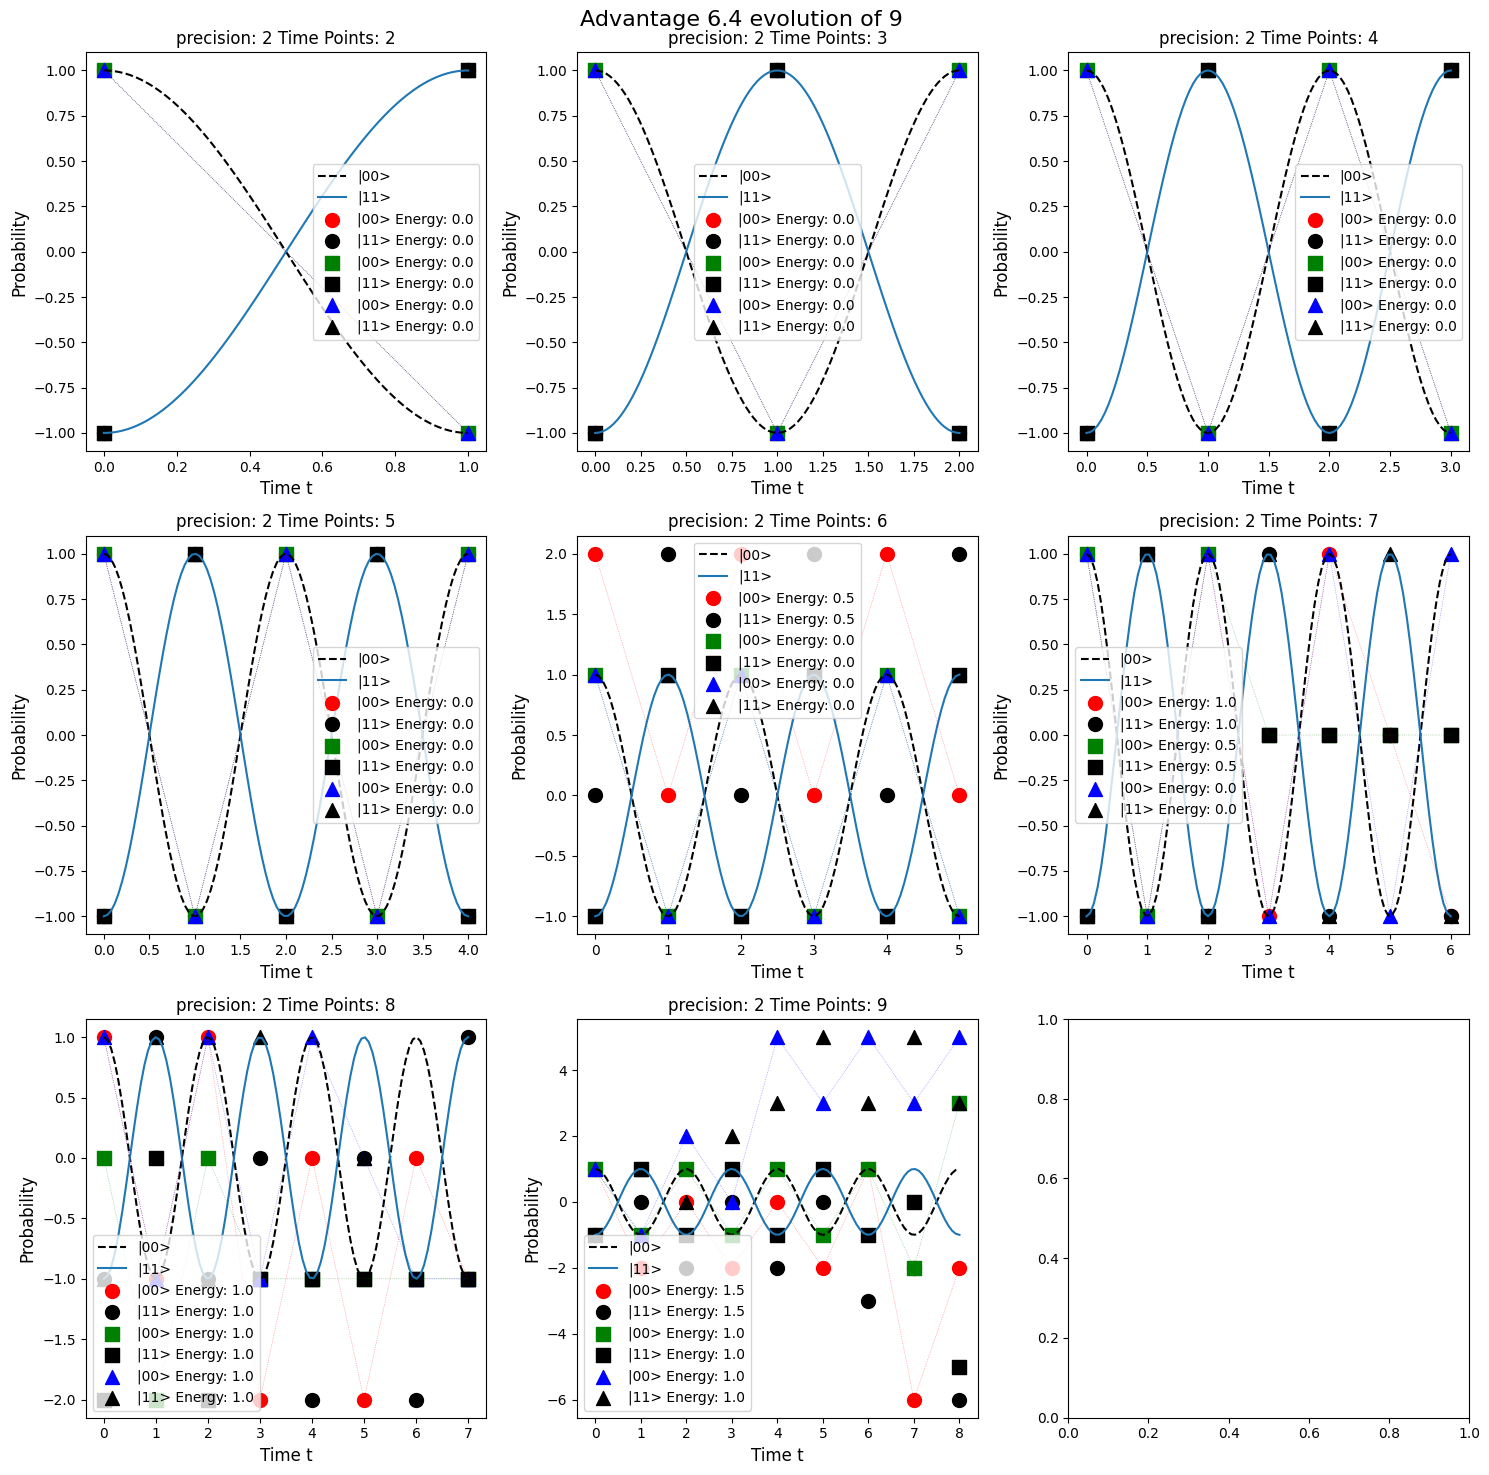

In [56]:
import qutip as qp

system = 9

dfs_data_raw = load_data(raw=True,system=system)
tp_pairs = get_precision_timepoints_pairs(dfs_data_raw)
tp_pairs.sort(key=lambda x: x[0]*10 + x[1])
dfs_data_raw['systemid']
# We simulate evolution under the Hamiltonian 1/2 pi * Sigma_y...

# Loop over all rows in velox_results and plot all dynamics on the same panel,
# coloring each curve according to its best_energy.
colors = ["r", "g", "b", "c", "m", "y", "k"]
markers = ["o", "s", "^", "D", "v", "<", ">"]

SY = np.array([[0, -1.0j], [1.0j, 0.0]])
PSI0 = np.array([1, 0], dtype=np.complex128)  # Difference b. Initial state can now be complex.


# Create a single axis for the plot
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=False)
axes = axes.flatten()

system_latex_dict = {
    1: 'H = $\frac{\pi}{2}\sigma_y$',
    3: 'one qubit pt symmetric system (seed=1)',
    4: 'maximally entangled 2 qubit system'
}




for i, (precision,timepoints) in enumerate(tp_pairs):
    inst = instance.Instance(system)
    inst.create_instance(precision, timepoints)
    H = inst.H
    PSI0 = inst.psi0
    dim = int(math.log2(H.shape[0]))    #dim=2

    print(H.shape)
    #H = instance['H']

    #baseline 
    # Projectors on |0..0⟩ and |1..1⟩
    #P_00 = qp.tensor([qp.basis(2, 0)]*dim).proj()
    #P_11 = qp.tensor([qp.basis(2, 1)]*dim).proj()

    P_00 = qp.tensor([qp.sigmaz()]+ [qp.qeye(2)]*(dim-1))
    P_11 = qp.tensor([qp.qeye(2)]*(dim-1) + [qp.sigmaz()])

    H_qp = qp.Qobj(H,dims=[[2]*dim,[2]*dim])

    psi_0 = qp.Qobj(PSI0)
    psi_0.dims = [[2]*dim, [1]]  # Naprawa błędu wymiarów

    #psi_0 = qp.tensor(qp.basis(2, 0), qp.basis(2, 1))
    times = np.linspace(0, timepoints-1, 100)
    baseline = qp.mesolve(H_qp, psi_0, times, e_ops=[P_00,P_11]).expect
    ax = axes[i]

    ax.plot(times, baseline[0], "k--",label="|00>")
    ax.plot(times, baseline[1],label="|11>")


    problem = inst.problem
    dfs_filtered = dfs_data_raw[(dfs_data_raw.precision == precision) & (dfs_data_raw.timepoints == timepoints)]
    dfs_filtered = dfs_filtered.drop(['num_occurrences'],axis=1)
    dfs_filtered.drop_duplicates(inplace=True)
    dfs_filtered = dfs_filtered.sort_values(by='energy').head(3)
    dfs_filtered = dfs_filtered.sort_values(by='energy',ascending=False)
    energies = list(dfs_filtered['energy'])
    dfs_filtered = dfs_filtered.filter(regex='\d+')
    dfs_filtered = dfs_filtered.apply(pd.to_numeric)
    for j, (_, row) in enumerate(dfs_filtered.iterrows()): 
        sol_dict = row.dropna().to_dict()
        sol_dict = {key:value for key,value in sol_dict.items()}

        vec =problem.interpret_sample(sol_dict)

        expect_00 = [(state.conj() @ P_00.full() @ state).real for state in vec]
        expect_11 = [(state.conj() @ P_11.full() @ state).real for state in vec]

        ax.scatter(problem.times, expect_00, color=colors[j % len(colors)], marker=markers[j % len(markers)], label=f"|00> Energy: {round(energies[j],4)}", alpha=1.0, s=100)
        ax.scatter(problem.times, expect_11, color='black', marker=markers[j % len(markers)],label=f"|11> Energy: {round(energies[j],4)}", alpha=1.0, s=100)
        ax.plot(problem.times, expect_00, alpha=0.5, color=colors[j % len(colors)], linestyle=':', linewidth=0.5)
    ax.set_xlabel("Time t", fontsize=12)
    ax.set_ylabel(r"Probability", fontsize=12)
    ax.set_title(f"precision: {problem.num_bits_per_var} Time Points: {len(problem.times)}")


    ax.legend()
fig.suptitle(f"Advantage {topology} " +rf"evolution of {system} ",fontsize=16)
plt.tight_layout()
#plt.savefig(f'../plots/system{topology}_dynamic_{system}.pdf')
plt.show()



In [ ]:
helpers.create_entangled_parity_hamiltonian(2)

(array([[0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
        [0.        +0.j, 0.        +0.j, 0.78539816+0.j, 0.        +0.j],
        [0.        +0.j, 0.78539816+0.j, 0.        +0.j, 0.        +0.j],
        [0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j]]),
 array([[0.+0.j],
        [1.+0.j],
        [0.+0.j],
        [0.+0.j]]))

In [ ]:
helpers.return_tts(0.006,0.18)

137.74022454944586

# Performance comparison Velox vs D-Wave

---------- System 2 ----------
  source  precision  num_var  timepoints   runtime  success_prob      tts99
0  VELOX          2     16.0           2  0.009201      0.297498   0.119992
1  VELOX          2     24.0           3  0.007437      0.195672   0.157278
2  VELOX          2     32.0           4  0.008176      0.017296   2.158109
3  VELOX          2     40.0           5  0.007930      0.011255   3.226313
4  DWAVE          2     16.0           2  0.292467      0.195755   6.182464
5  DWAVE          2     24.0           3  0.298753      0.066603  19.960982
6  DWAVE          2     32.0           4  0.297459      0.034233  39.327098
7  DWAVE          2     40.0           5  0.318871      0.018382  79.149693
---------- System 4 ----------
  source  precision  num_var  timepoints   runtime  success_prob        tts99
0  VELOX          2     32.0           2  0.007896      0.096290     0.359164
1  VELOX          2     48.0           3  0.008304      0.078197     0.469687
2  VELOX          2 

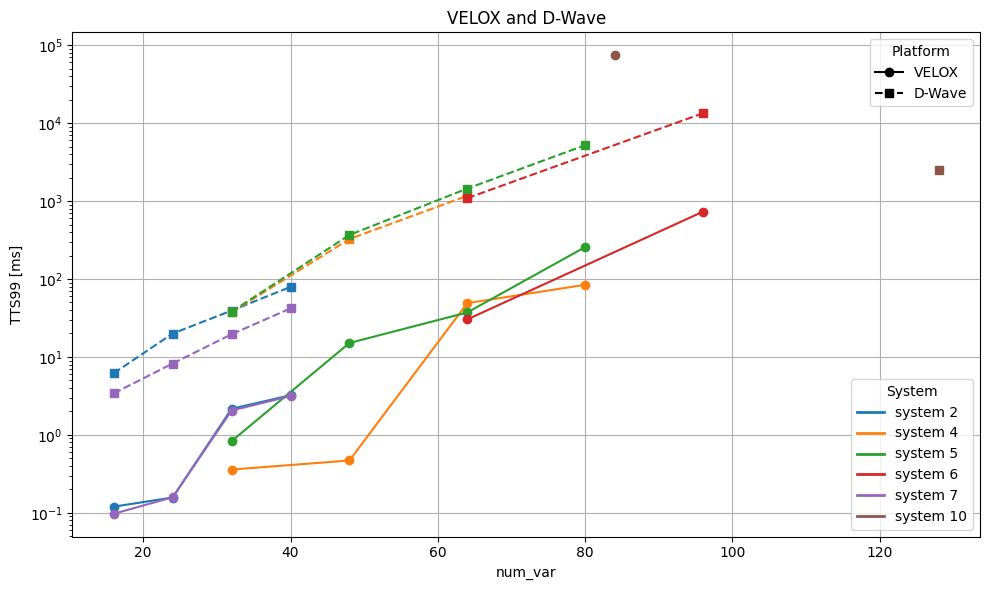

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.tab10.colors  # do 10 systemów
systems = [2, 4, 5, 6, 7,10]
from matplotlib.lines import Line2D
for idx, system in enumerate(systems):
    df1_filtered = helpers.get_velox_success_rates(system)
    df2_filtered = helpers.get_dwave_success_rates(system=system)

    # Dodajemy identyfikator źródła
    df1_filtered['source'] = 'VELOX'
    df2_filtered['source'] = 'DWAVE'

    # Łączymy oba DataFrame'y
    combined = pd.concat([df1_filtered,df2_filtered])
    # Reset indeksu do kolumn
    combined = combined.reset_index()
    # Tworzymy etykiety X
    combined['system'] = system
    combined['x_label'] = combined['precision'].astype(str) + '\n' + combined['timepoints'].astype(str)
    combined['tts99'] = combined.apply(lambda row: helpers.return_tts(row['success_prob'],row.runtime),axis=1)
    #print(combined[['system','num_var','precision','timepoints','source','runtime','success_prob','tts99']].to_latex(escape=True))
    df = combined.copy()
    

    velox = df[df['source'] == 'VELOX'].dropna(subset=['num_var', 'tts99'])
    dwave = df[df['source'] == 'DWAVE'].dropna(subset=['num_var', 'tts99'])
    print(f'---------- System {system} ----------')
    print(combined[['source','precision','num_var','timepoints','runtime','success_prob','tts99']])
    color = colors[idx % len(colors)]
    
    ax.plot(velox['num_var'], velox['tts99'],
            marker='o', linestyle='-', color=color, label=f'system {system}')
    
    ax.plot(dwave['num_var'], dwave['tts99'],
            marker='s', linestyle='--', color=color)

# Legenda 1: styl/metoda
style_legend = [
    Line2D([0], [0], color='black', linestyle='-', marker='o', label='VELOX'),
    Line2D([0], [0], color='black', linestyle='--', marker='s', label='D-Wave')
]

legend1 = ax.legend(handles=style_legend, title='Platform', loc='upper right')

# Legenda 2: kolory/systemy
color_legend = [
    Line2D([0], [0], color=colors[idx % len(colors)], lw=2, label=f'system {s}') for idx, s in enumerate(systems)
]

legend2 = ax.legend(handles=color_legend, title='System', loc='lower right')
ax.add_artist(legend1)  # dodaj pierwszą legendę z powrotem do osi

# Oś, tytuł itd.
ax.set_xlabel('num_var')
ax.set_ylabel('TTS99 [ms]')
ax.set_yscale('log')
ax.grid(True)
ax.set_title('VELOX and D-Wave')
plt.tight_layout()
plt.show()


---------- System 1 ----------
  source  precision  num_var  timepoints   runtime  success_prob       tts99
0  DWAVE          2     16.0           2  0.299233      0.169041    7.441739
1  DWAVE          2     24.0           3  0.296803      0.065302   20.239902
2  DWAVE          2     32.0           4  0.308130      0.031605   44.184823
3  DWAVE          2     40.0           5  0.318722      0.012218  119.394439
---------- System 2 ----------
  source  precision  num_var  timepoints   runtime  success_prob      tts99
0  DWAVE          2     16.0           2  0.292467      0.195755   6.182464
1  DWAVE          2     24.0           3  0.298753      0.066603  19.960982
2  DWAVE          2     32.0           4  0.297459      0.034233  39.327098
3  DWAVE          2     40.0           5  0.318871      0.018382  79.149693
---------- System 3 ----------
  source  precision  num_var  timepoints   runtime  success_prob        tts99
0  DWAVE          3     24.0           2  0.292266      0.000345

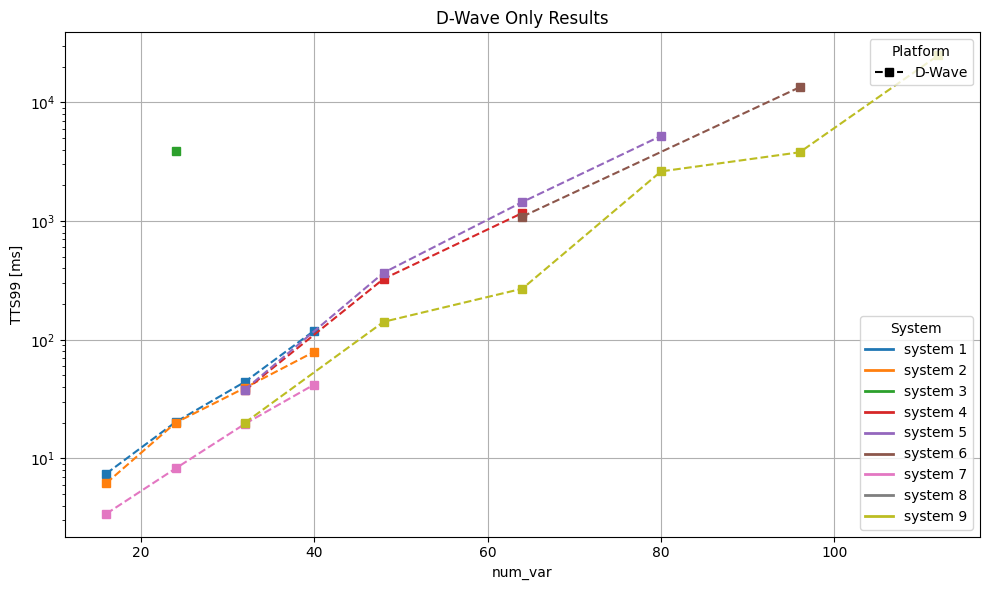

In [59]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.tab10.colors  # do 10 systemów
systems = [i for i in range(1,10)]
from matplotlib.lines import Line2D

for idx, system in enumerate(systems):
    # Tylko D-Wave
    df2_filtered = helpers.get_dwave_success_rates(system=system)
    df2_filtered['source'] = 'DWAVE'
    df2_filtered = df2_filtered.reset_index()
    df2_filtered['system'] = system
    df2_filtered['x_label'] = df2_filtered['precision'].astype(str) + '\n' + df2_filtered['timepoints'].astype(str)
    df2_filtered['tts99'] = df2_filtered.apply(lambda row: helpers.return_tts(row['success_prob'], row.runtime), axis=1)
    
    df = df2_filtered.dropna(subset=['num_var', 'tts99'])

    print(f'---------- System {system} ----------')
    print(df[['source', 'precision', 'num_var', 'timepoints', 'runtime', 'success_prob', 'tts99']])

    color = colors[idx % len(colors)]
    ax.plot(df['num_var'], df['tts99'],
            marker='s', linestyle='--', color=color, label=f'system {system}')

# Legenda: kolory / systemy
color_legend = [
    Line2D([0], [0], color=colors[idx % len(colors)], lw=2, label=f'system {s}') for idx, s in enumerate(systems)
]

# Styl D-Wave tylko
style_legend = [
    Line2D([0], [0], color='black', linestyle='--', marker='s', label='D-Wave')
]

legend1 = ax.legend(handles=style_legend, title='Platform', loc='upper right')
legend2 = ax.legend(handles=color_legend, title='System', loc='lower right')
ax.add_artist(legend1)

# Oś, tytuł itd.
ax.set_xlabel('num_var')
ax.set_ylabel('TTS99 [ms]')
ax.set_yscale('log')
ax.grid(True)
ax.set_title('D-Wave Only Results')
plt.tight_layout()
plt.show()


   index  precision  timepoints  num_steps       runtime   num_rep  \
0      0          2           2     1000.0  1.530215e-05  524280.0   
1      1          2           3     1000.0  8.644441e-07  524280.0   
2      2          2           4     1000.0  9.160250e-07  524280.0   
3      3          2           5     1000.0  1.043662e-06  524280.0   
4      0          2           2        NaN  3.043558e-01       NaN   
5      1          2           3        NaN  3.010032e-01       NaN   
6      2          2           4        NaN  3.194976e-01       NaN   
7      3          2           5        NaN  3.077667e-01       NaN   

   success_prob source topology  
0      0.297498    DF1      NaN  
1      0.195672    DF1      NaN  
2      0.017296    DF1      NaN  
3      0.011255    DF1      NaN  
4      0.023530    DF2      6.4  
5      0.001373    DF2      6.4  
6      0.000390    DF2      6.4  
7      0.000000    DF2      6.4  


,index,precision,timepoints,num_steps,runtime,num_rep,success_prob,source,topology,x_label,tts99
0,0,2,2,1000.0,1.530215e-05,524280.0,0.297498,DF1,NaN,2\n2,0.000200
1,1,2,3,1000.0,8.644441e-07,524280.0,0.195672,DF1,NaN,2\n3,0.000018
2,2,2,4,1000.0,9.160250e-07,524280.0,0.017296,DF1,NaN,2\n4,0.000242
3,3,2,5,1000.0,1.043662e-06,524280.0,0.011255,DF1,NaN,2\n5,0.000425
4,0,2,2,NaN,3.043558e-01,NaN,0.023530,DF2,6.4,2\n2,58.862593
5,1,2,3,NaN,3.010032e-01,NaN,0.001373,DF2,6.4,2\n3,1008.800732
6,2,2,4,NaN,3.194976e-01,NaN,0.000390,DF2,6.4,2\n4,3769.574781
7,3,2,5,NaN,3.077667e-01,NaN,0.000000,DF2,6.4,2\n5,inf


/home/atg205/Documents/DWaveDynamics/.venv/lib/python3.13/site-packages/matplotlib/transforms.py:2436: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),
/home/atg205/Documents/DWaveDynamics/.venv/lib/python3.13/site-packages/matplotlib/transforms.py:2436: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),


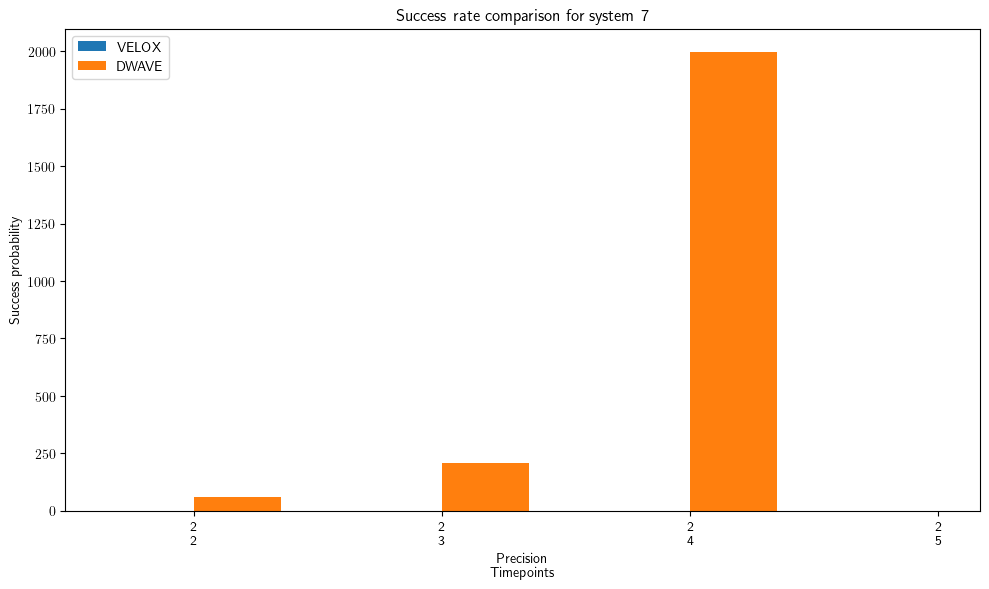

In [13]:
# Ustawienia wykresu
fig, ax = plt.subplots(figsize=(10, 6))

# Rysujemy słupki
sources = combined['source'].unique()
x_labels = combined['x_label'].unique()
x = range(len(x_labels))
bar_width = 0.35

for i, source in enumerate(sources):
    subset = combined[combined['source'] == source]
    offset = [xi + i * bar_width for xi in x]
    ax.bar(offset, subset['tts99'], width=bar_width, label=source)

# Oś X
ax.set_xticks([xi + bar_width / 2 for xi in x])
ax.set_xticklabels(x_labels)
ax.set_xlabel('Precision\nTimepoints')
ax.set_ylabel('Success probability')
ax.set_title(f'Success rate comparison for system {system}')
ax.legend()

plt.tight_layout()
plt.show()